## Семинар 3 "Определение ключевых точек лица"

ФИО: Сапаев Дилшод Рахимович

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU
from torch.autograd import Variable
from IPython.display import clear_output
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


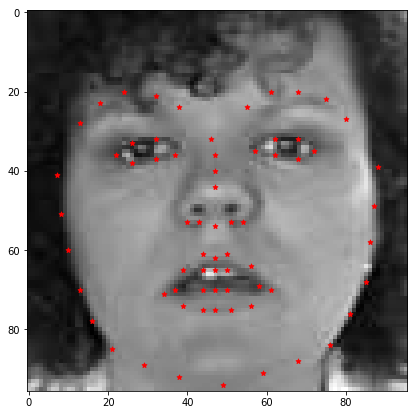

In [2]:
landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=25, marker='*', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure(figsize=(7, 7))
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)), landmarks)
plt.show()

In [3]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    plt.figure(figsize=(14, 7))

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=20, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=20, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [6]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

In [8]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam, alpha=1.0):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            learning_rate *= alpha
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            clear_output()
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))

            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs[1:], label='Train')
            plt.plot(test_loss_epochs[1:], label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
            
    except KeyboardInterrupt:
        pass
    return test_loss_epochs[1:]

In [9]:
# Почему MSE растет???
network = Sequential(Linear(1 * 96 * 96, 200), Tanh(), Linear(200, 2 * 68))

Epoch 3... (Train/Test) MSE: 19.579/21.884

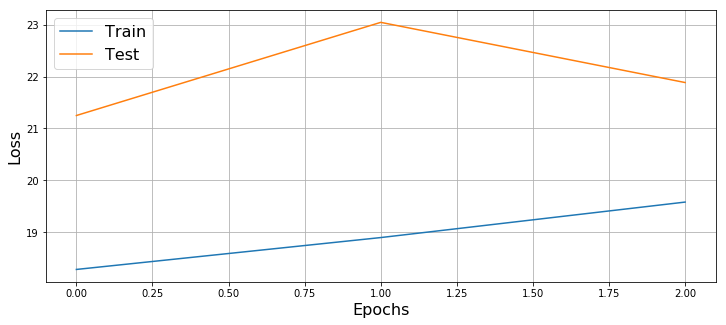

[18.280670195209737, 18.89536734989711, 19.57938004513176]

In [11]:
train(network, 4, 1e-1)

tensor([[141., 141., 139.,  ...,  20.,  21.,  20.],
        [ 52.,  53.,  53.,  ...,  61.,  58.,  96.]])
(2, 96, 96)


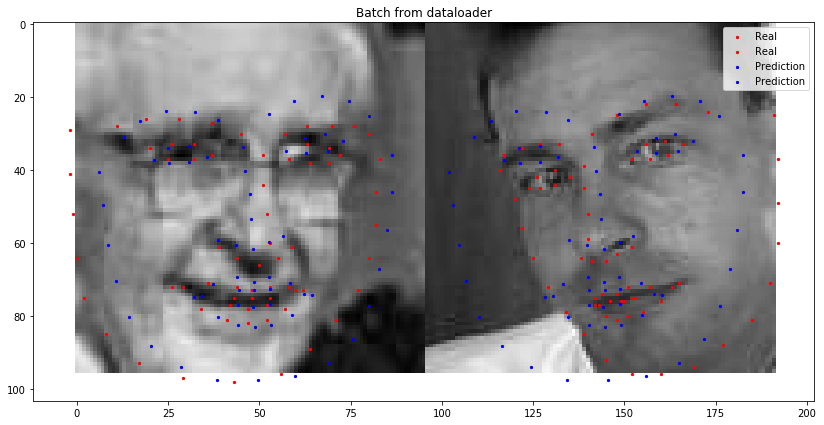

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
print(x)
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

Epoch 29... (Train/Test) MSE: 17.512/18.506

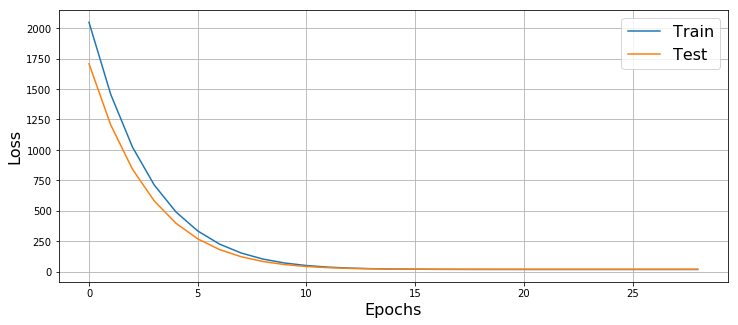

[2048.3543613978795,
 1455.788097148039,
 1022.7543963996732,
 711.566203837492,
 489.9741780806561,
 333.992609763632,
 225.94902303267497,
 152.380382070736,
 102.75466623111647,
 70.24447398283044,
 49.50671129810567,
 36.417680428952586,
 28.46013676390356,
 23.626984187534877,
 20.88117962467427,
 19.26055841056668,
 18.433201371407023,
 17.93999006310288,
 17.71581795750832,
 17.63450188539466,
 17.508002436890894,
 17.507117144915522,
 17.48486681373752,
 17.51186515847031,
 17.493394073174926,
 17.46345296198008,
 17.430018590421092,
 17.46666230960768,
 17.512169302726278]

In [17]:
train(network, 30, 1e-1, alpha=0.95)

(2, 96, 96)


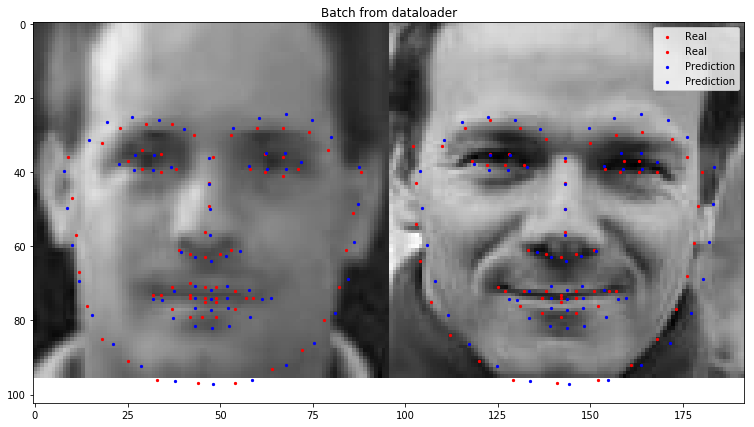

In [20]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

In [10]:
### Собственно, само домашнее задание

In [11]:
network_1_tanh = Sequential(Linear(1 * 96 * 96, 200), Tanh(), Linear(200, 2 * 68))
network_1_relu = Sequential(Linear(1 * 96 * 96, 200), ReLU(), Linear(200, 2 * 68))
network_1_elu = Sequential(Linear(1 * 96 * 96, 200), ELU(), Linear(200, 2 * 68))
network_1_sigm = Sequential(Linear(1 * 96 * 96, 200), Sigmoid(), Linear(200, 2 * 68))

network_2_tanh = Sequential(Linear(1 * 96 * 96, 200), Tanh(), Linear(200, 200), Tanh(), Linear(200, 2 * 68))
network_2_relu = Sequential(Linear(1 * 96 * 96, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 2 * 68))
network_2_elu = Sequential(Linear(1 * 96 * 96, 200), ELU(), Linear(200, 200), ELU(), Linear(200, 2 * 68))
network_2_sigm = Sequential(Linear(1 * 96 * 96, 200), Sigmoid(), Linear(200, 200), Sigmoid(), Linear(200, 2 * 68))

Epoch 29... (Train/Test) MSE: 20.352/29.952

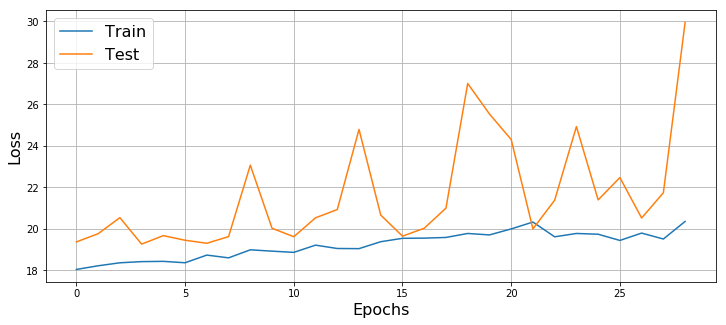

CPU times: user 13min 52s, sys: 35.4 s, total: 14min 27s
Wall time: 6min 42s


In [12]:
# В душе не е** почему MSE растет
%time loss_1_tanh = train(network_1_tanh, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 17.529/18.522

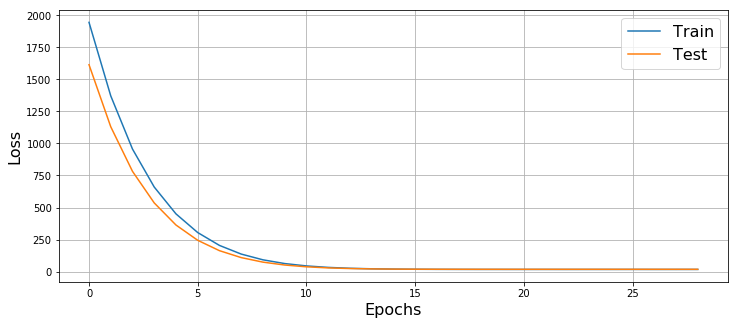

CPU times: user 2min 55s, sys: 18.5 s, total: 3min 13s
Wall time: 3min 12s


In [21]:
%time loss_1_relu = train(network_1_relu, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 31.242/29.007

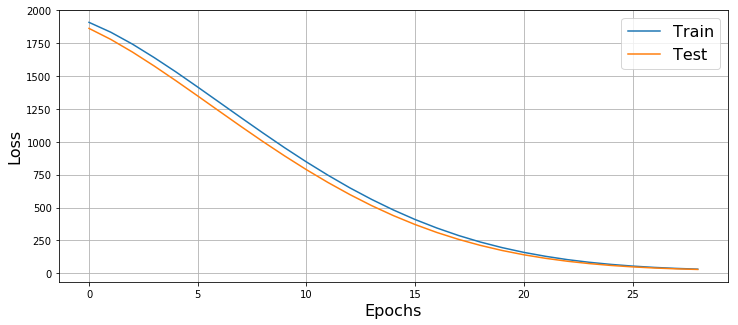

CPU times: user 14min 11s, sys: 35.4 s, total: 14min 47s
Wall time: 6min 42s


In [14]:
%time loss_1_elu = train(network_1_elu, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 18.717/19.405

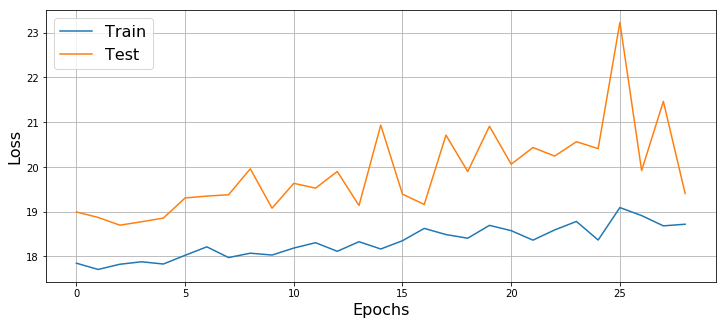

CPU times: user 41min 52s, sys: 42 s, total: 42min 34s
Wall time: 21min 16s


In [15]:
%time loss_1_sigm = train(network_1_sigm, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 19.595/20.541

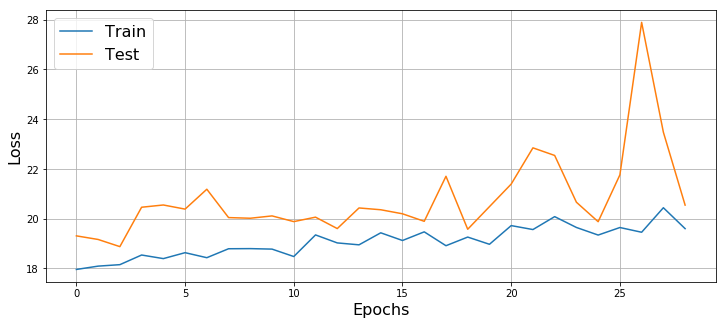

CPU times: user 12min 29s, sys: 37.2 s, total: 13min 6s
Wall time: 6min 51s


In [16]:
%time loss_2_tanh = train(network_2_tanh, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 17.706/18.896

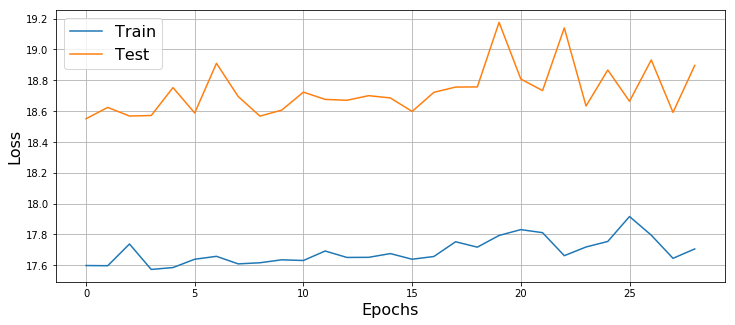

CPU times: user 12min 44s, sys: 39.3 s, total: 13min 23s
Wall time: 7min 24s


In [17]:
%time loss_2_relu = train(network_2_relu, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 20.354/19.368

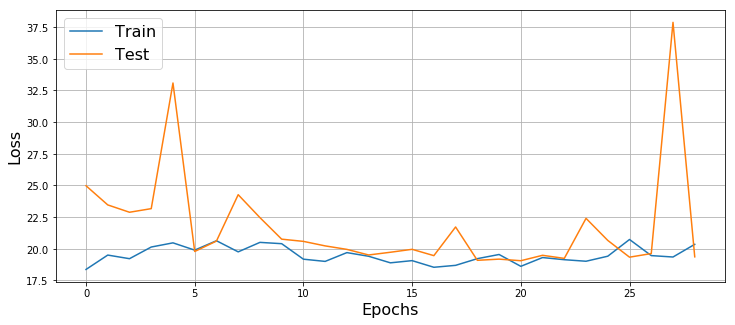

CPU times: user 3min 12s, sys: 21.6 s, total: 3min 34s
Wall time: 3min 7s


In [23]:
%time loss_2_elu = train(network_2_elu, 30, 1e-1, alpha=0.95)

Epoch 29... (Train/Test) MSE: 18.516/20.171

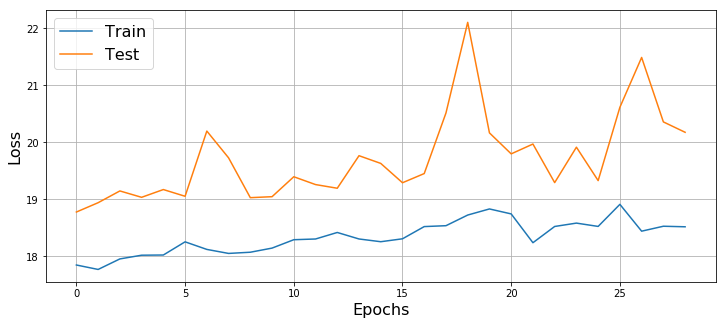

CPU times: user 14min 17s, sys: 39.9 s, total: 14min 56s
Wall time: 7min 22s


In [19]:
%time loss_2_sigm = train(network_2_sigm, 30, 1e-1, alpha=0.95)

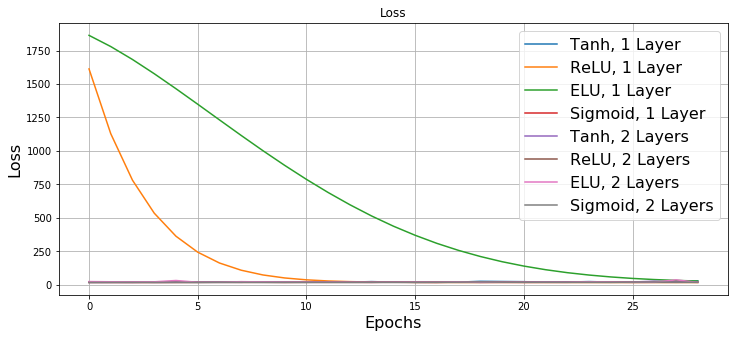

In [26]:
plt.figure(figsize=(12, 5))
plt.title('Loss')
plt.plot(loss_1_tanh, label='Tanh, 1 Layer')
plt.plot(loss_1_relu, label='ReLU, 1 Layer')
plt.plot(loss_1_elu, label='ELU, 1 Layer')
plt.plot(loss_1_sigm, label='Sigmoid, 1 Layer') # просто не туда привоил результат случайно
plt.plot(loss_2_tanh, label='Tanh, 2 Layers')
plt.plot(loss_2_relu, label='ReLU, 2 Layers')
plt.plot(loss_2_elu, label='ELU, 2 Layers')
plt.plot(loss_2_sigm, label='Sigmoid, 2 Layers')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

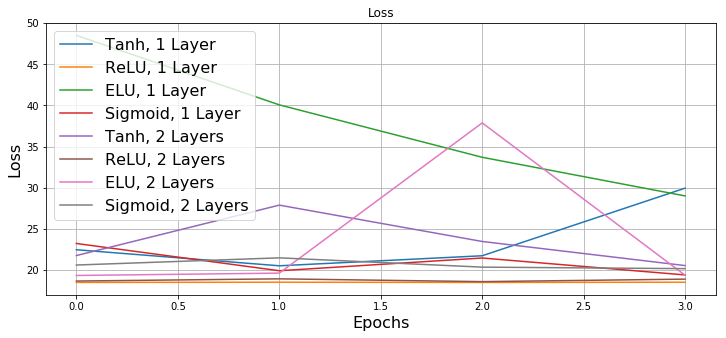

In [30]:
plt.figure(figsize=(12, 5))
plt.title('Loss')
plt.plot(loss_1_tanh[25:], label='Tanh, 1 Layer')
plt.plot(loss_1_relu[25:], label='ReLU, 1 Layer')
plt.plot(loss_1_elu[25:], label='ELU, 1 Layer')
plt.plot(loss_1_sigm[25:], label='Sigmoid, 1 Layer') # просто не туда привоил результат случайно
plt.plot(loss_2_tanh[25:], label='Tanh, 2 Layers')
plt.plot(loss_2_relu[25:], label='ReLU, 2 Layers')
plt.plot(loss_2_elu[25:], label='ELU, 2 Layers')
plt.plot(loss_2_sigm[25:], label='Sigmoid, 2 Layers')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()